# Number of guests prediction demo

Stripped-down version of [this notebook](https://www.kaggle.com/code/atasaygin/hotel-booking-demand-eda-and-of-guest-prediction).

**Performance** 
- Hotel booking demand dataset
    - Test MAPE City Hotel: 0.249210
    - Test MAPE Resort Hotel: 0.241623
- Lumen dataset `data/raw/lumen_dataset`

# Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error
import os

for dirname, _, filenames in os.walk('../data/raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

../data/raw\booking_demand\hotel-booking-demand-eda-and-of-guest-prediction.ipynb
../data/raw\booking_demand\hotel_bookings.csv
../data/raw\lumen_dataset\export_df.parquet


In [2]:
data = pd.read_parquet('../data/raw/lumen_dataset/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hotel_id                       119210 non-null  int32         
 1   datum_dolaska                  119210 non-null  datetime64[ns]
 2   datum_kreiranja_rezervacije    119210 non-null  datetime64[ns]
 3   datum_odjave                   119210 non-null  datetime64[ns]
 4   datum_otkazivanja_rezervacije  44199 non-null   object        
 5   broj_odraslih_gostiju          119210 non-null  int64         
 6   broj_djece_gostiju             119210 non-null  float64       
 7   zemlja_gosta                   119210 non-null  object        
 8   kanal_prodaje_id               119210 non-null  int32         
 9   tip_sobe_id                    119210 non-null  int32         
 10  cijena_nocenja                 119210 non-null  float64       
 11  

**Some features have wrong datatype. I need to fix that for the following steps.**

In [4]:
NaN = data.isna().sum()
NaN

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

**For the following step, I will drop the NaN values by dropping the columns or the rows.**

# Data Cleaning

In [5]:
# data = data.drop(['company', 'agent'], axis=1)
data = data.dropna(subset=['zemlja_gosta', 'broj_djece_gostiju'], axis=0)
data = data.reset_index(drop=True)
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [6]:
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)
data['broj_djece_gostiju'].dtype #It is correct now!

dtype('int32')

In [7]:
# Checking for the missing values after drops
NaN_updated = data.isna().sum()
NaN_updated

hotel_id                             0
datum_dolaska                        0
datum_kreiranja_rezervacije          0
datum_odjave                         0
datum_otkazivanja_rezervacije    75011
broj_odraslih_gostiju                0
broj_djece_gostiju                   0
zemlja_gosta                         0
kanal_prodaje_id                     0
tip_sobe_id                          0
cijena_nocenja                       0
status_rezervacije                   0
rezervacija_id                       0
gost_id                              0
dtype: int64

In [8]:
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0,GBR,2,1,130.973278,Check-Out,1313227,1093703


# Creating New Features

In [9]:
# Calculating total guests for each record
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']
data['ukupno_gostiju'].head(10)

0    2
1    2
2    1
3    1
4    2
5    2
6    2
7    2
8    2
9    2
Name: ukupno_gostiju, dtype: int64

In [10]:
# Some data points include zero Total Guests, therefore I dropped them
data = data[data['ukupno_gostiju'] != 0]

In [11]:
# Total Number of Days Stayed -- ovo nemamo
# data['Total Stays'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']

dataNoCancel = data[data['datum_otkazivanja_rezervacije'] != None]
dataNoCancel = dataNoCancel.reset_index(drop=True)

In [12]:
# Calculating Number of Guests Weekly - Resort Hotel
NumberOfGuests = data[['datum_dolaska', 'ukupno_gostiju']]
NumberOfGuestsWeekly = data['ukupno_gostiju'].groupby(data['datum_dolaska']).sum()
NumberOfGuestsWeekly = NumberOfGuestsWeekly.resample('w').sum().to_frame()
NumberOfGuestsWeekly.head()

,ukupno_gostiju
datum_dolaska,
2015-01-04,44
2015-01-11,69
2015-01-18,85
2015-01-25,80
2015-02-01,44


# ARIMA Model for Predicting Future Number of Guests


In [13]:
# Dickey-Fuller Test to City Hotel Data
WeeklyValues = NumberOfGuestsWeekly.values
result = adfuller(WeeklyValues)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.335667
p-value: 0.160722
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


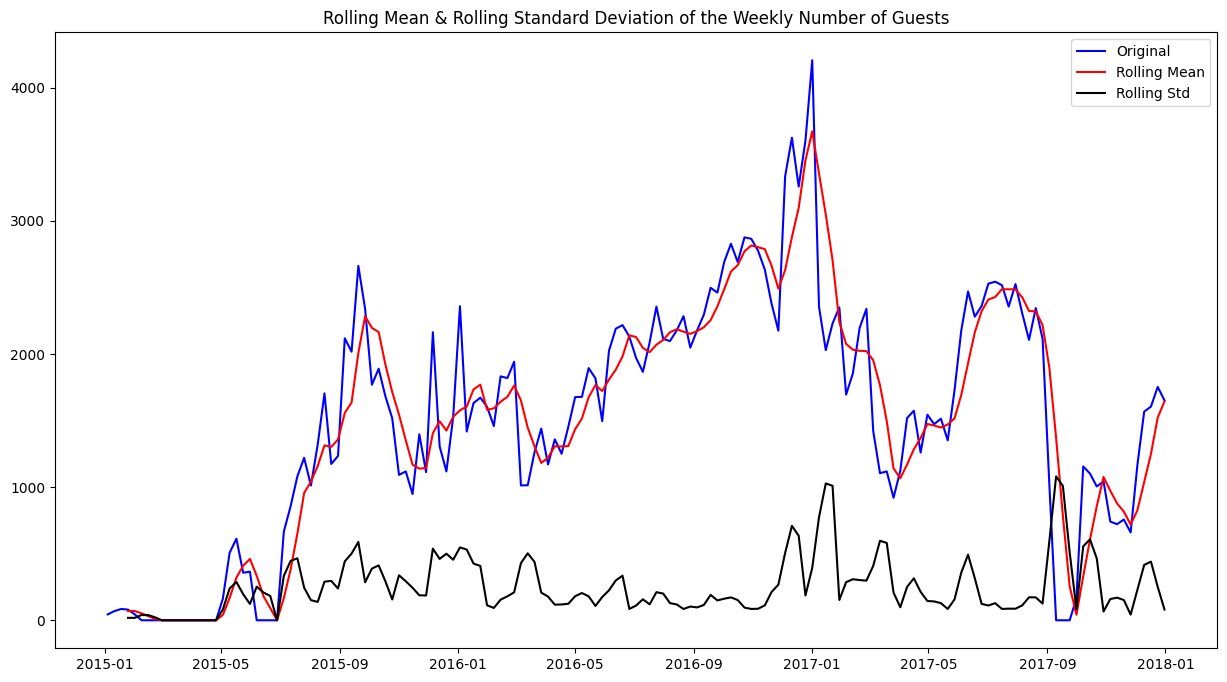

In [14]:
# Rolling Mean & Rolling Standard Deviation of City Hotel
plt.figure(figsize=(15, 8))
rolling_mean = NumberOfGuestsWeekly.rolling(window=4).mean()
rolling_std = NumberOfGuestsWeekly.rolling(window=4).std()
plt.plot(NumberOfGuestsWeekly, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Rolling Mean & Rolling Standard Deviation of the Weekly Number of Guests')
plt.show()

In [15]:
train_test_split = 110 # int(len(NumberOfGuestsWeekly)*0.8)

trainData = NumberOfGuestsWeekly[:train_test_split]
testData = NumberOfGuestsWeekly[train_test_split:]

In [16]:
# Fit auto_arima function to NumberOfGuests_CityWeekly Dataset
stepwise_fit = auto_arima(trainData['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1558.520, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1477.885, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1578.291, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1484.944, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1471.387, Time=2.05 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1541.530, Time=1.70 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1472.926, Time=2.73 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1472.809, Time=2.56 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1498.736, Time=1.94 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1474.858, Time=2.01 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  110
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -730.693
Date:                            Fri, 09 Feb 2024   AIC                           1471.387
Time:                                    15:56:47   BIC                           1484.312
Sample:                                01-04-2015   HQIC                          1476.615
                                     - 02-05-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    148.8427     85.837      1.734      0.083     -19.395     317.080
ar.L1          0.7350      0.066     11.096      0.000       0.605       0.865
ar.S.L12      -0.4516      0.101     -4.466      0.000      -0.650      -0.253
ar.S.L24      -0.3200      0.179     -1.790      0.073      -0.670       0.030
sigma2      1.689e+05    2.1e+04      8.027      0.000    1.28e+05     2.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                11.99
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -0.15
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
model = ARIMA(trainData['ukupno_gostiju'],
                  order=(3, 0, 0),
                  seasonal_order=(2, 1, 0, 12))

result = model.fit()

# Prediction of the Test data
predictionsTest = result.predict(train_test_split, train_test_split + len(testData) - 1, typ='levels').rename("Predictions")

# Prediction of Number of Guests (Test Data)


Text(0, 0.5, 'Number of Guests')

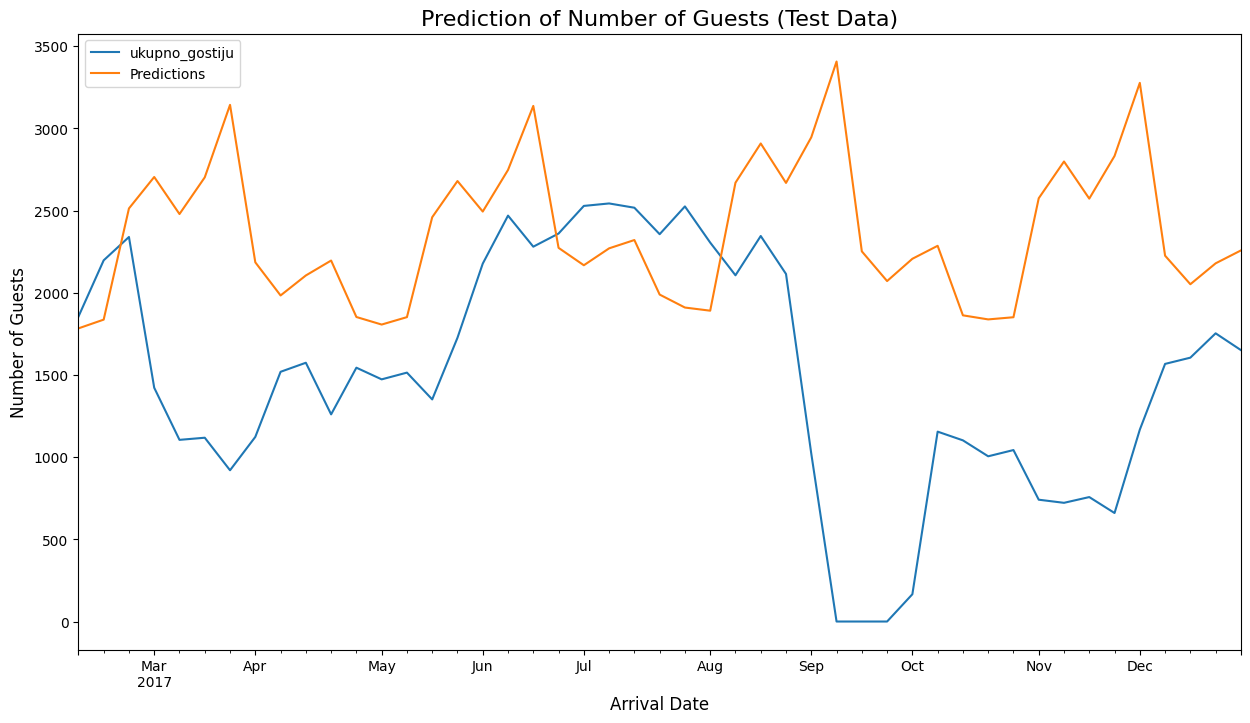

In [18]:
plt.figure(figsize=(15, 8))
testData['ukupno_gostiju'].plot(legend=True)
predictionsTest.plot(legend=True)
plt.title('Prediction of Number of Guests (Test Data)', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

# Prediction of Number of Guests


Text(0, 0.5, 'Number of Guests')

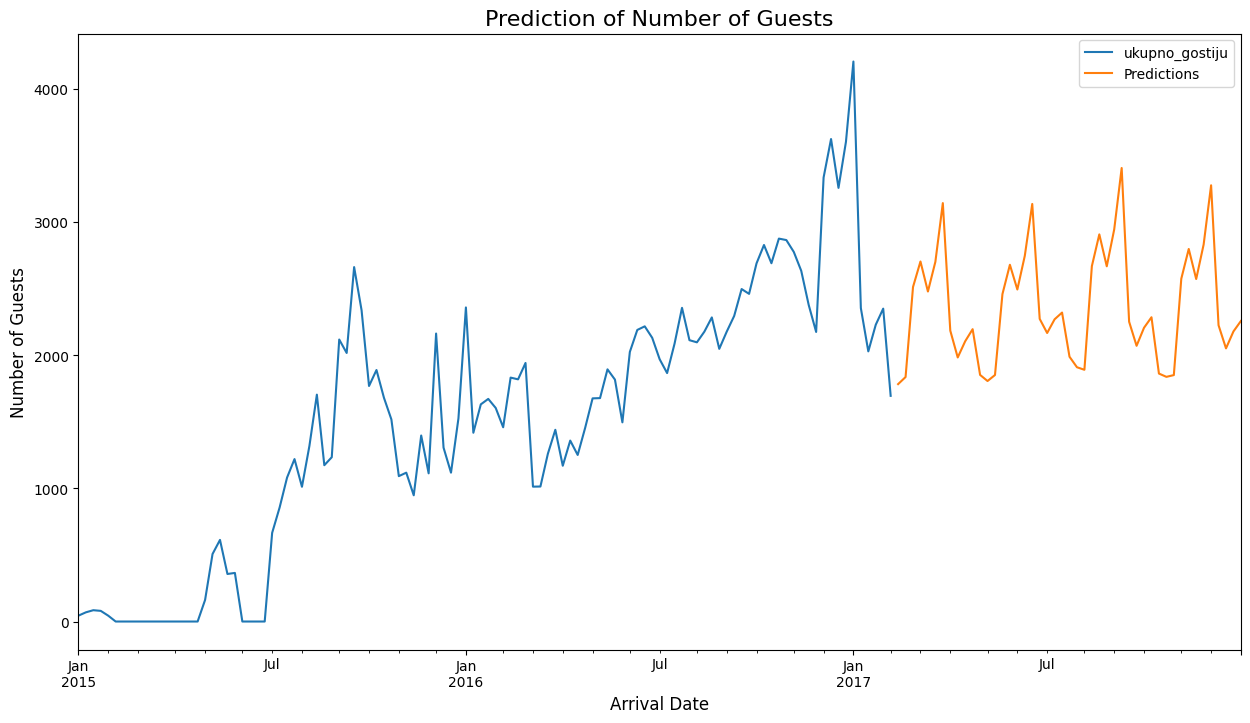

In [19]:
plt.figure(figsize=(15, 8))
trainData['ukupno_gostiju'].plot(legend=True)
predictionsTest.plot(legend=True)
plt.title('Prediction of Number of Guests', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Number of Guests', fontsize=12)

In [20]:
MeanAbsPercentageErr_test = mean_absolute_percentage_error(testData, predictionsTest)
print('Test MAPE: %f' % MeanAbsPercentageErr_test)

Test MAPE: 740583604438715648.000000
